In [145]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelBinarizer
from bs4 import BeautifulSoup
from requests import get
import re

In [146]:
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [149]:
X_train, y_train = (train[["Distance", "DepTime"]].values, 
train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values)
X_test = test[["Distance", "DepTime"]].values

X_train_part, X_valid, y_train_part, y_valid = (
    train_test_split(X_train, y_train, test_size=0.3, random_state=17))

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [150]:
logit = LogisticRegression()
logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, logit_valid_pred)

0.67956914653526068

In [151]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:,1]
pd.Series(logit_test_pred, name="dep_delayed_15min").to_csv('logit_2feat.csv', index_label='id', header=True)

# EDA

In [152]:
def get_int_value(value):
    if type(value) != str:
        return value
    return int(value.replace("c-", ""))

def to_sin(value, max_value):
    angle = 2. * np.pi * get_int_value(value) / max_value
    return np.sin(angle)

def to_cos(value, max_value):
    angle = 2. * np.pi * get_int_value(value) / max_value
    return np.cos(angle)

def convert_time(t):
    h = t / 100
    m = float(t % 100) / 60
    return h + m

In [323]:
def preprocess(X):
    X["Flight"] = X["Origin"] + "-" + X["Dest"]
    X["Hour"] = X["DepTime"] // 100
    X["Month"] = X["Month"].apply(lambda x: x.replace("c-", ""))
    X["DayOfMonth"] = X["DayofMonth"].apply(lambda x: x.replace("c-", ""))
    X = X.drop(["DayofMonth"], axis=1)
    X["DayOfWeek"] = X["DayOfWeek"].apply(lambda x: x.replace("c-", ""))
#     X = X.drop(["Origin", "Dest"], axis=1)
#     X["DayOfWeekSin"] = X["DayOfWeek"].apply(lambda x: to_sin(x, 7))
#     X["DayOfWeekCos"] = X["DayOfWeek"].apply(lambda x: to_cos(x, 7))
#     X = X.drop(["DayOfWeek"], axis=1)
    
#     X["DayOfMonthSin"] = X["DayofMonth"].apply(lambda x: to_sin(x, 31))
#     X["DayOfMonthCos"] = X["DayofMonth"].apply(lambda x: to_cos(x, 31))
#     X = X.drop(["DayofMonth"], axis=1)
    
#     X["MonthSin"] = X["Month"].apply(lambda x: to_sin(x, 12))
#     X["MonthCos"] = X["Month"].apply(lambda x: to_cos(x, 12))
#     X = X.drop(["Month"], axis=1)
    
#     X["DepTimeSin"] = X["DepTime"].apply(lambda x: to_sin(convert_time(x), 24))
#     X["DepTimeCos"] = X["DepTime"].apply(lambda x: to_cos(convert_time(x), 24))
#     X = X.drop(["DepTime"], axis=1)

    airport_to_state = pd.read_csv("airport_to_state.csv", usecols=["airport", "state"])
    X = X.merge(airport_to_state, left_on="Origin", right_on="airport", how="left")
#     X = pd.get_dummies(X, columns=["Flight", "UniqueCarrier"])
    if "dep_delayed_15min" in X.columns:
        X["dep_delayed_15min"] = X["dep_delayed_15min"].map({"Y": 1, "N":0})
    
    return X

In [324]:
X = preprocess(train.copy())
X.head()

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Flight,Hour,DayOfMonth,airport,state
0,8,7,1934,AA,ATL,DFW,732,0,ATL-DFW,19,21,ATL,GA
1,4,3,1548,US,PIT,MCO,834,0,PIT-MCO,15,20,PIT,PA
2,9,5,1422,XE,RDU,CLE,416,0,RDU-CLE,14,2,RDU,NC
3,11,6,1015,OO,DEN,MEM,872,0,DEN-MEM,10,25,DEN,CO
4,10,6,1828,WN,MDW,OMA,423,1,MDW-OMA,18,7,MDW,IL


In [106]:
# X_train, X_test, y_train, y_test = train_test_split(X.drop(["dep_delayed_15min"], axis=1), X["dep_delayed_15min"], test_size=0.3, random_state=17)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# logit = LogisticRegression(n_jobs=-1)
# logit.fit(X_train_scaled, y_train)
# y_pred = logit.predict_proba(X_test_scaled)[:, 1]
# roc_auc_score(y_test, y_pred)
# cl = XGBClassifier()
# cl.fit(X_train, y_train)
# y_pred = cl.predict(X_test)
# roc_auc_score(y_test, y_pred)

In [158]:
airports = X["Dest"].unique()

In [159]:
# states = [get_state_by_airport_code(x) for x in airports]


# Вероятность задержки по дням недели

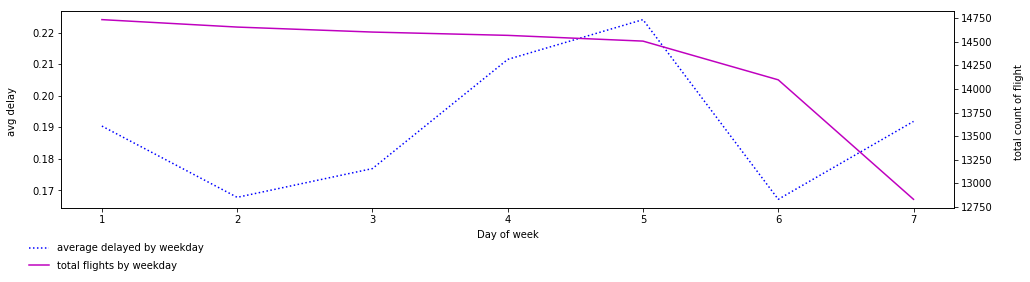

In [266]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,8), X.groupby("DayOfWeek").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by weekday")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,8), list(X["DayOfWeek"].value_counts()), color='m')
line2.set_label("total flights by weekday")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of week', ha='center')
ax0.text(0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

# Задержки по дням месяца

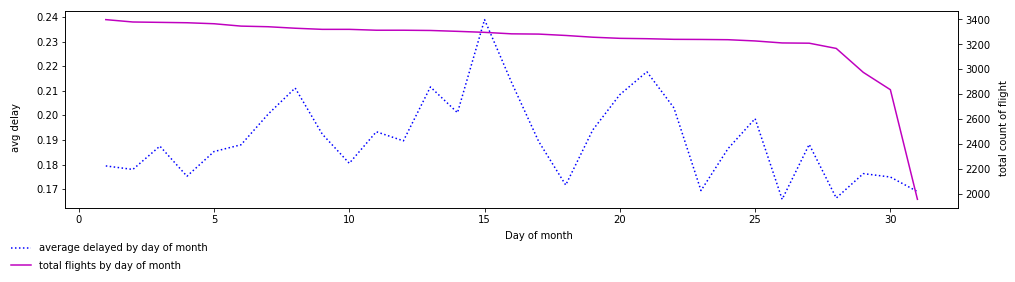

In [173]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,32), X.groupby("DayOfMonth").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by day of month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,32), list(X["DayOfMonth"].value_counts()), color='m')
line2.set_label("total flights by day of month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(17, 0.15, 'Day of month', ha='center')
ax0.text(-2.5, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(34, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

# Задержки по часам

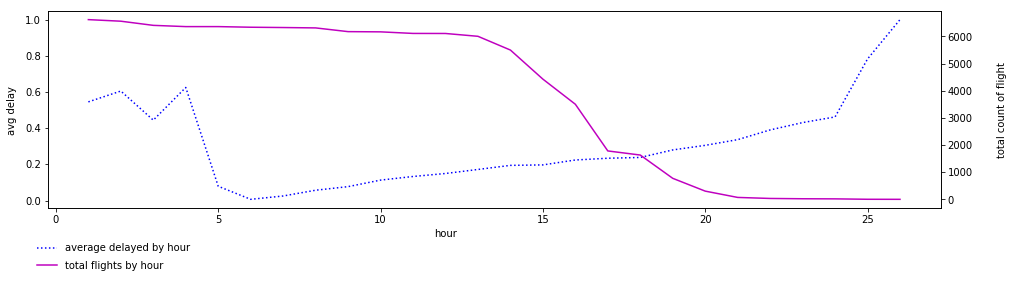

In [188]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,27), X.groupby("Hour").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by hour")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,27), list(X["Hour"].value_counts()), color='m')
line2.set_label("total flights by hour")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(12, -0.2, 'hour', ha='center')
ax0.text(-1.5, 0.5, 'avg delay', va='center', rotation='vertical')
ax0.text(29, 0.5, 'total count of flight', va='center', rotation='vertical')
plt.show()

# Задержки по месяцам

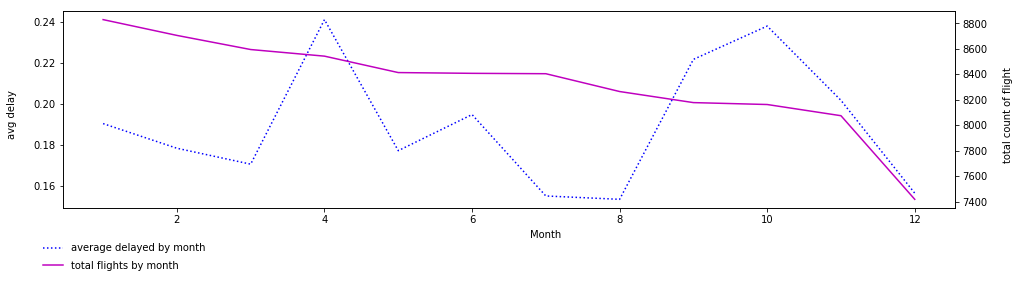

In [196]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,13), X.groupby("Month").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,13), list(X["Month"].value_counts()), color='m')
line2.set_label("total flights by month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(7, 0.135, 'Month', ha='center')
ax0.text(-0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(13.2, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

# Зависимость опоздания от расстояния перелета

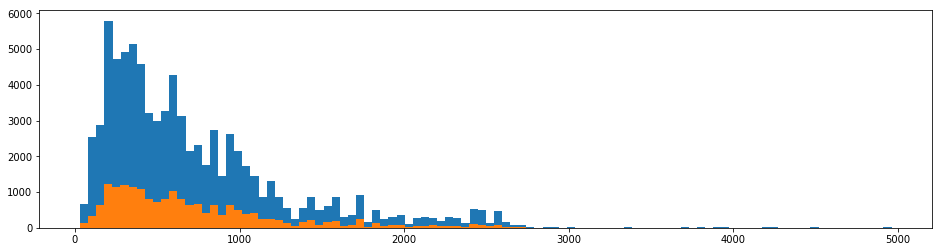

In [201]:
plt.figure(figsize=(16,4))
plt.hist(X['Distance'][X['dep_delayed_15min'] == 0], bins=100)
plt.hist(X['Distance'][X['dep_delayed_15min'] == 1], bins=100)
plt.show()

# Проверим данные на корректность

In [197]:
# Проверяем, что расстояние между всеми пунктами не меняется
Z = X.groupby("Flight").agg({"Distance": [np.max, np.min]})
np.sum(Z["Distance"]["amax"] - Z["Distance"]["amin"]) == 0

True

In [200]:
# Количество различных аэропортов назначения и отбытия
len(X["Dest"].unique()), len(X["Origin"].unique())

(289, 289)

In [356]:
len(np.unique(X['Flight'])), len(np.unique(X['Distance']))

(4429, 1310)

# Тепловая карта 

In [353]:
import os
import folium
import json
import branca.colormap as cm

In [364]:
linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=1)
linear

In [332]:
state_json_data = json.load(open("us-states.json"))

In [333]:
states_delay = X.groupby("state").agg([np.mean])["dep_delayed_15min"]

In [344]:
states = [x["id"] for x in state_json_data["features"]]

In [351]:
flight_delay_states = states_delay.index.tolist()

In [352]:
# штаты, которых нет в геоданных.
set(flight_delay_states) - set(states)

{'PR', 'VI'}

In [361]:
max_delay = states_delay.max()
min_delay = states_delay.min()
states_delay /= (max_delay - min_delay)

In [ ]:
m = folium.Map([43, -100], tiles='cartodbpositron', zoom_start=4)

folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': linear(states_delay.get_value(feature['id'], "mean")),
        'color': 'black',
        'weight': 2,
        'dashArray': '5'
    })

0.92156836992235636

# отладка всякая

In [25]:
(X
 .groupby('Origin')
 .agg({'dep_delayed_15min': np.mean})
 .sort_values(by=["dep_delayed_15min"], ascending=False).head())

,dep_delayed_15min
Origin,
GST,1.000000
ADK,1.000000
AKN,1.000000
LWB,0.750000
BRW,0.714286


In [51]:
# def get_state_by_airport_code(code):
#     url = "https://www.airport.wiki/{airport}/"
#     page_source = get(url.format(airport=code)).text
#     s = BeautifulSoup(page_source, "lxml")
#     fields = s.find_all(name = "div", attrs={'class': 'airport-inner-detail'})
#     if not fields or len(fields) <= 2:
#         print ("Problem with airport: {code}".format(code=code))
#         return "NOT FOUND"
#     address = fields[1].text
#     try:
#         state = address.split(",")[-2].strip().split(" ")[0].strip()
#     except:
#         print("problem with adress: {a}".format(a=address))
#         return "NOT FOUND"
#     return state

In [286]:
# get_state_by_airport_code("AKN")

In [320]:
# air = pd.DataFrame(airports, columns=["airport"])
# st = pd.DataFrame(states, columns=["state"])
# airport_to_state = pd.concat([air, st], axis=1)
# airport_to_state.at['YUM', 'state'] = "AZ"
# airport_to_state.at['FCA', 'state'] = 'MT'
# airport_to_state.at['MQT', 'state'] = 'MI'
# airport_to_state.at['SJU', 'state'] = 'PR' # Пуэрто Рико
# airport_to_state.at['ISO', 'state'] = 'NC'
# airport_to_state.at['CLD', 'state'] = 'CA'
# airport_to_state.at['TUP', 'state'] = 'MS'
# airport_to_state.at['MEI', 'state'] = 'MS'
# airport_to_state.at['SCE', 'state'] = 'PA'
# airport_to_state.at['STT', 'state'] = 'VI' # Virgin Island
# airport_to_state.at['STX', 'state'] = 'VI'# Virgin Island
# airport_to_state.at['VIS', 'state'] = 'CA'
# airport_to_state.at['IPL', 'state'] = 'CA'
# airport_to_state.at['PFN', 'state'] = 'FL'
# airport_to_state.at['OXR', 'state'] = 'CA'
# airport_to_state.at['IYK', 'state'] = 'CA'
# airport_to_state.at['BQN', 'state'] = 'PR' # Пуэрто Рико
# airport_to_state.at['CDC', 'state'] = 'UT'
# airport_to_state.at['APF', 'state'] = 'FL'
# airport_to_state.at['MCN', 'state'] = 'GA'
# airport_to_state.at['ILG', 'state'] = 'DE'
# airport_to_state.at['OTZ', 'state'] = 'AK'
# airport_to_state.at['HKY', 'state'] = 'NA'
# airport_to_state.at['SOP', 'state'] = 'NA'
# airport_to_state.at['WYS', 'state'] = 'MT'
# airport_to_state.at['PSE', 'state'] = 'PR' # Пуэрто Рико
# airport_to_state.at['TEX', 'state'] = 'CO'
# airport_to_state.at['VCT', 'state'] = 'TX'
# airport_to_state.at["MSP", 'state'] = "MN"

In [322]:
# airport_to_state.to_csv("airport_to_state.csv")

In [321]:
airport_to_state[airport_to_state['state'] == "Minnesota"]

,airport,state
